In [405]:
import kagglehub

path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/fedesoriano/heart-failure-prediction/versions/1


In [406]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [407]:
file_name = [file for file in os.listdir(path) if file.endswith('.csv')][0]
file_path = os.path.join(path, file_name)
data = pd.read_csv(file_path)

In [408]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [409]:
data.shape

(918, 12)

In [410]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [411]:
data['Sex'] = data['Sex'].map({'M': 1, 'F': 0})
data['ChestPainType'] = data['ChestPainType'].map({'ATA': 0, 'NAP': 1, 'ASY': 2, 'TA': 3})
data['RestingECG'] = data['RestingECG'].map({'Normal': 0, 'ST': 1, 'LVH': 2})
data['ST_Slope'] = data['ST_Slope'].map({'Up': 0, 'Flat': 1, 'Down': 2})
data['ExerciseAngina'] = data['ExerciseAngina'].map({'N': 0, 'Y': 1})
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,0,140,289,0,0,172,0,0.0,0,0
1,49,0,1,160,180,0,0,156,0,1.0,1,1
2,37,1,0,130,283,0,1,98,0,0.0,0,0
3,48,0,2,138,214,0,0,108,1,1.5,1,1
4,54,1,1,150,195,0,0,122,0,0.0,0,0


In [412]:
data = data.drop(columns=["ChestPainType", "FastingBS", "RestingECG", "MaxHR", "ExerciseAngina", "Oldpeak", "ST_Slope"])
data = data.rename(columns={"Sex": "C_Sex", "HeartDisease": "C_HeartDisease"}) # C stands for context only, not meant to be analyzed
selected_columns = ["Age", "RestingBP", "Cholesterol"]
data.head()

,Age,C_Sex,RestingBP,Cholesterol,C_HeartDisease
0,40,1,140,289,0
1,49,0,160,180,1
2,37,1,130,283,0
3,48,0,138,214,1
4,54,1,150,195,0


In [413]:
data.describe()

,Age,C_Sex,RestingBP,Cholesterol,C_HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,0.789760,132.396514,198.799564,0.553377
std,9.432617,0.407701,18.514154,109.384145,0.497414
min,28.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,1.000000,120.000000,173.250000,0.000000
50%,54.000000,1.000000,130.000000,223.000000,1.000000
75%,60.000000,1.000000,140.000000,267.000000,1.000000
max,77.000000,1.000000,200.000000,603.000000,1.000000


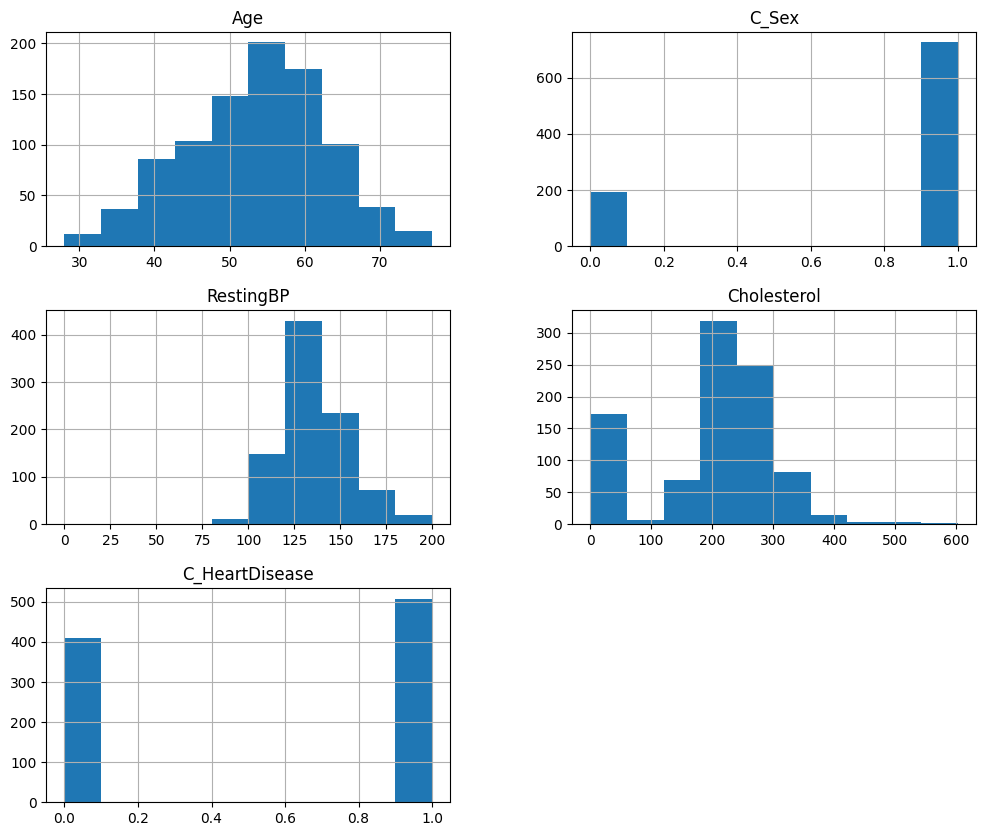

In [414]:
data.hist(figsize=(12, 10))
plt.show()

In [415]:
def remove_outliers_iqr(df, selected_columns):
    print("Hello from IQR method function.")
    for column in selected_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [416]:
def remove_outliers_std(df, selected_columns, threshold=3):
    print("Hello from STD method function.")
    for column in selected_columns:
        mean = df[column].mean()
        std = df[column].std()
        lower_bound = mean - threshold * std
        upper_bound = mean + threshold * std
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

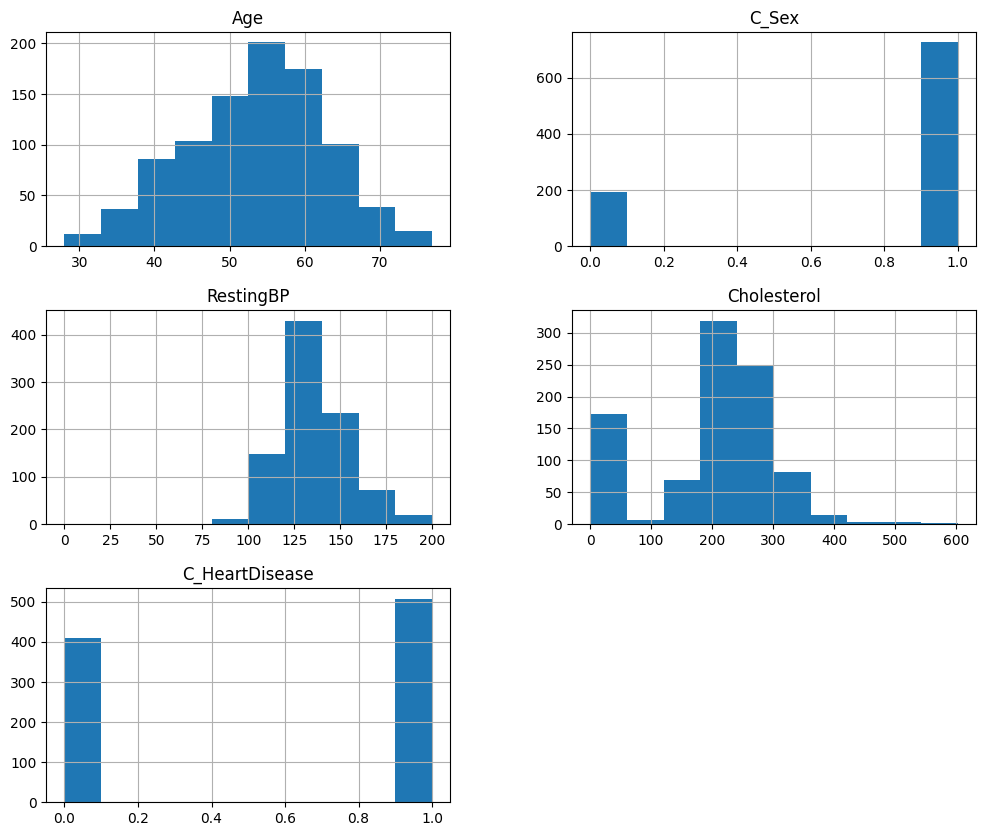

In [417]:
data.hist(figsize=(12, 10))
plt.show()

In [418]:
def outlier_runner(out_func):
  global data
  print(f"Data size before: {data.shape}")
  data = out_func(data, selected_columns)
  print(f"Data size after: {data.shape}")

In [419]:
outlier_runner(remove_outliers_iqr)

scaler = MinMaxScaler()  # StandardScaler()
data[selected_columns] = scaler.fit_transform(data[selected_columns])
data.head()

Data size before: (918, 5)
Hello from IQR method function.
Data size after: (713, 5)


,Age,C_Sex,RestingBP,Cholesterol,C_HeartDisease
0,0.244898,1,0.615385,0.660194,0
1,0.428571,0,0.871795,0.307443,1
2,0.183673,1,0.487179,0.640777,0
3,0.408163,0,0.589744,0.417476,1
4,0.530612,1,0.743590,0.355987,0


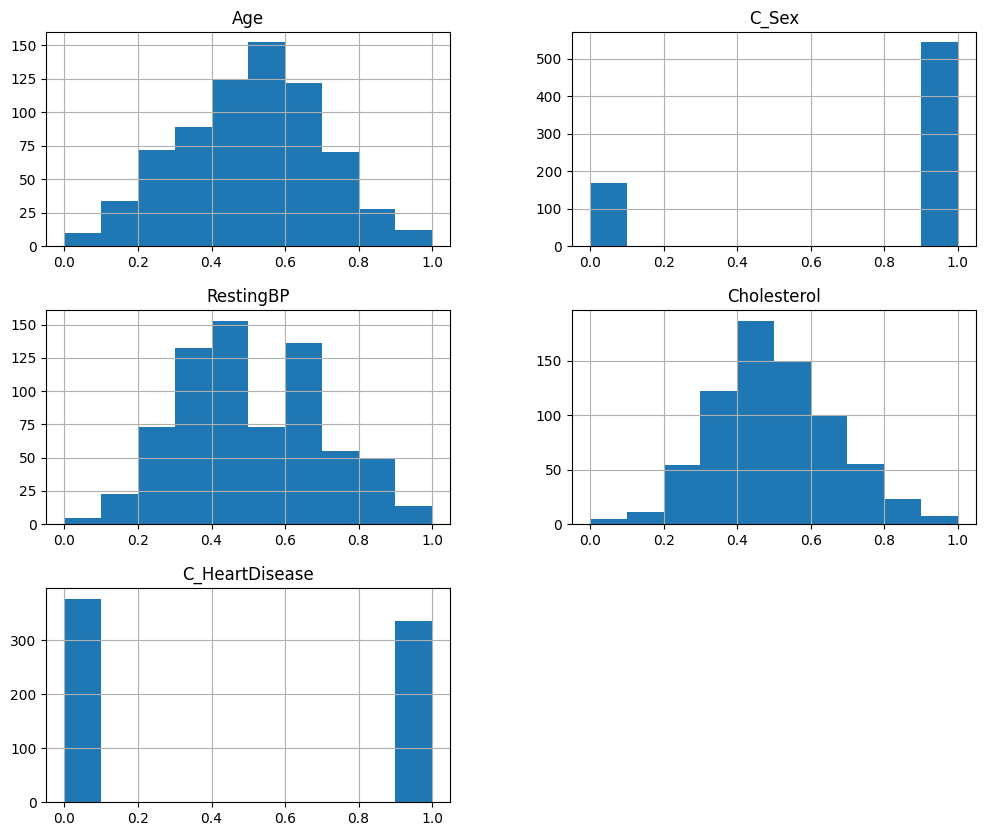

In [420]:
data.hist(figsize=(12, 10))
plt.show()

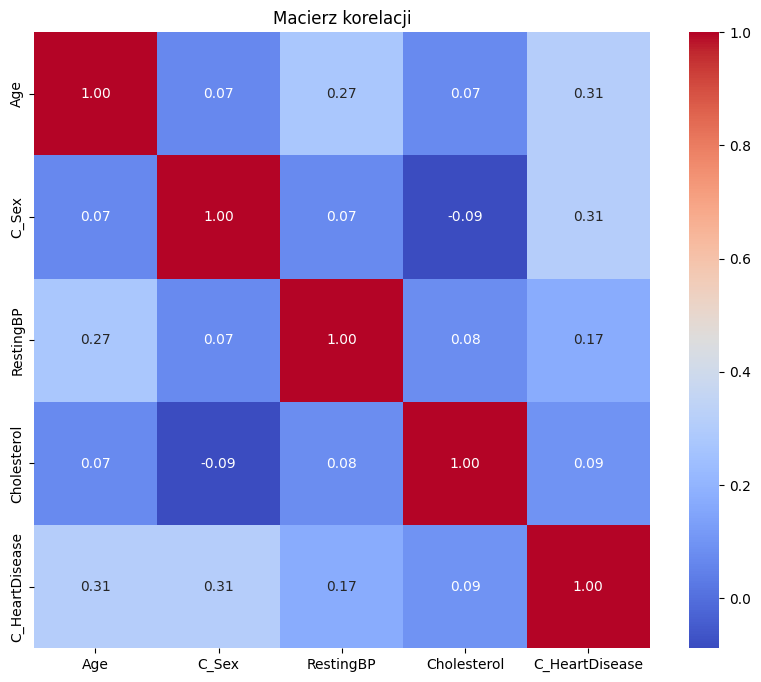

In [421]:
correlation_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True
)
plt.title("Macierz korelacji")
plt.show()

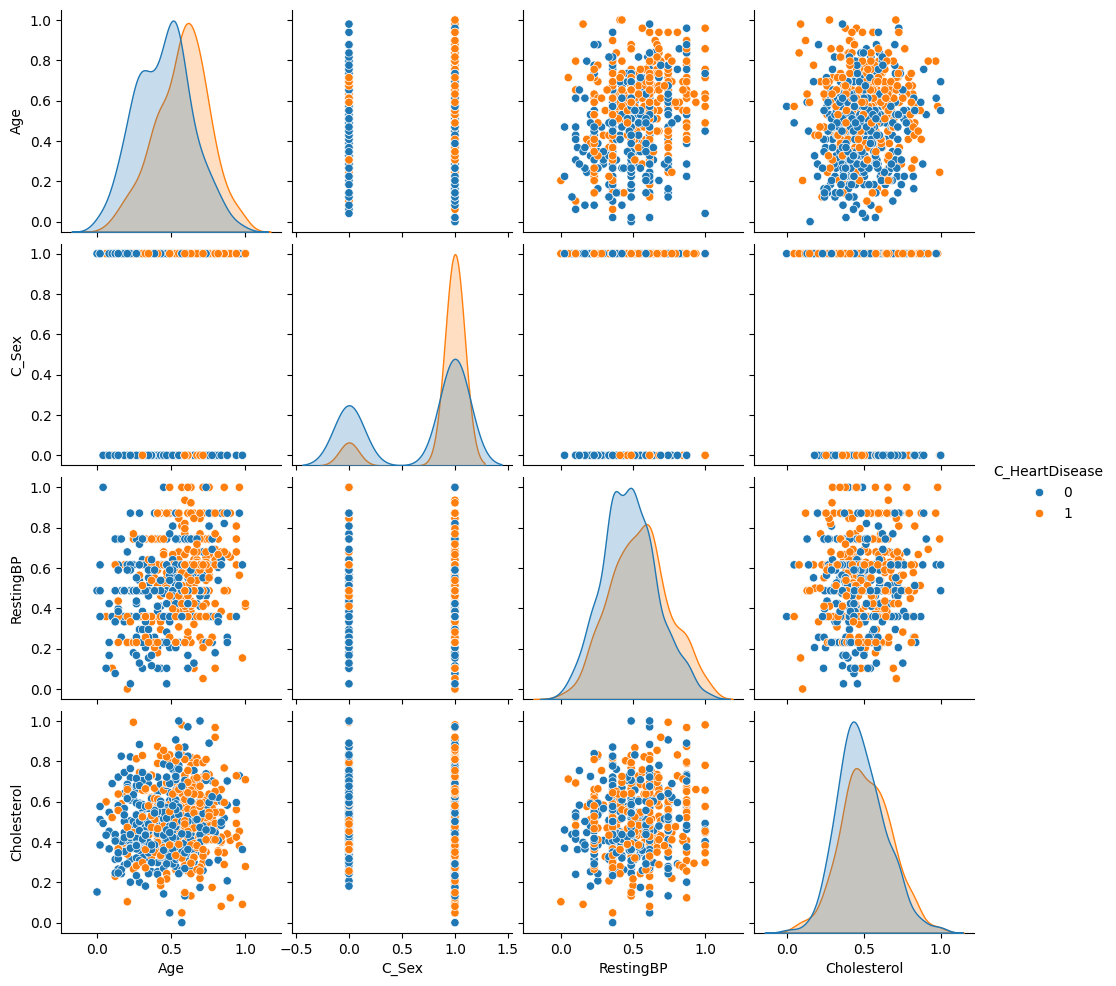

In [422]:
sns.pairplot(data, hue='C_HeartDisease')
plt.show()

In [423]:
warnings.filterwarnings("ignore", category=FutureWarning)

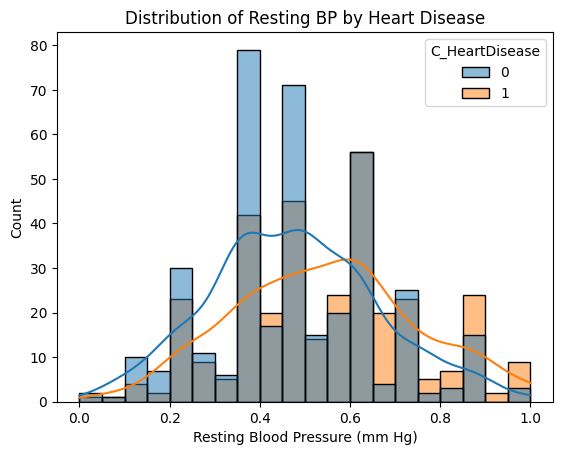

In [424]:
sns.histplot(x='RestingBP', hue='C_HeartDisease', data=data, kde=True, bins=20)
plt.title('Distribution of Resting BP by Heart Disease')
plt.xlabel('Resting Blood Pressure (mm Hg)')
plt.show()

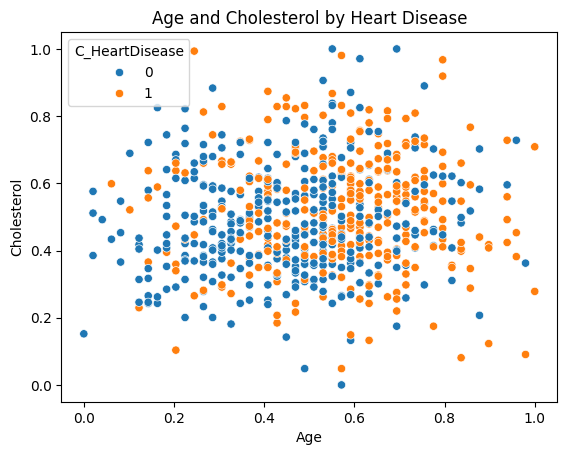

In [425]:
sns.scatterplot(x='Age', y='Cholesterol', hue='C_HeartDisease', data=data)
plt.title('Age and Cholesterol by Heart Disease')
plt.xlabel('Age')
plt.ylabel('Cholesterol')
plt.show()

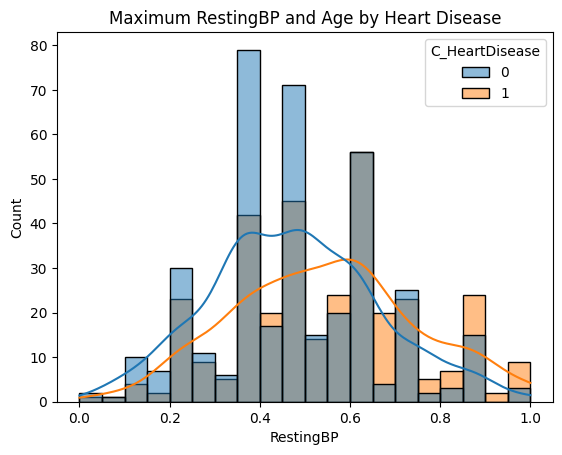

In [426]:
sns.histplot(x='RestingBP', hue='C_HeartDisease', data=data, kde=True, bins=20)
plt.title('Maximum RestingBP and Age by Heart Disease')
plt.show()

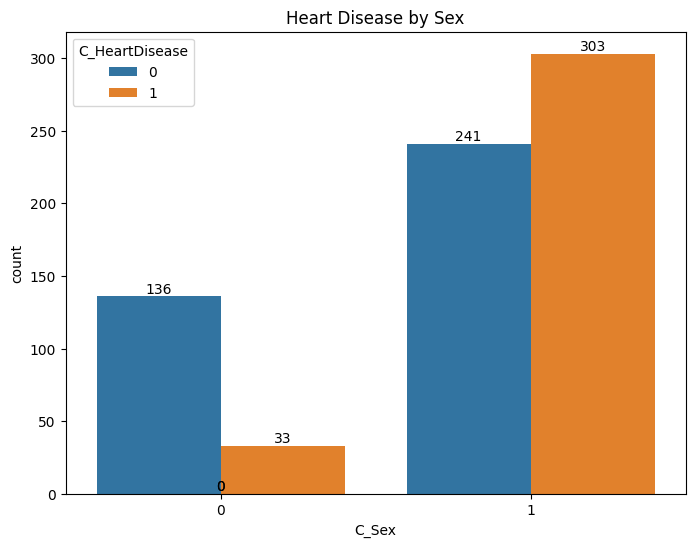

In [427]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='C_Sex', hue='C_HeartDisease', data=data)
plt.title('Heart Disease by Sex')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()

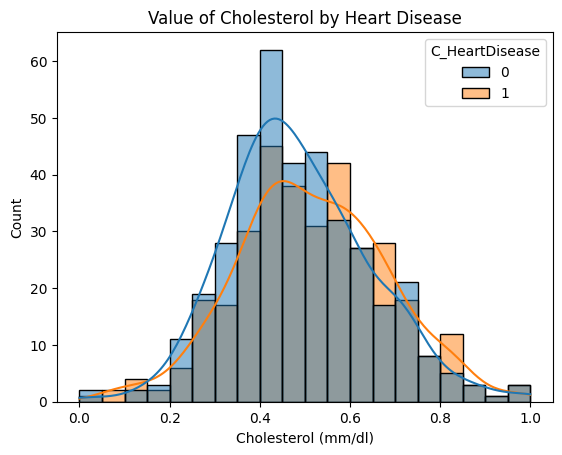

In [428]:
sns.histplot(x='Cholesterol', hue='C_HeartDisease', data=data, kde=True, bins=20)
plt.title('Value of Cholesterol by Heart Disease')
plt.xlabel('Cholesterol (mm/dl)')
plt.show()
# Wartości 0 cholesterolu bo nie zmierzone.

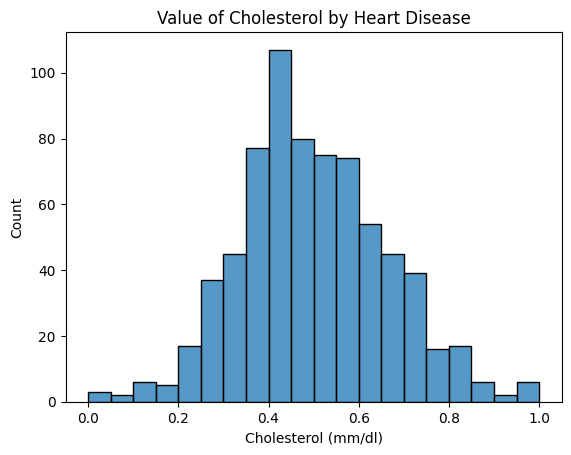

In [429]:
sns.histplot(x='Cholesterol', data=data, bins=20)
plt.title('Value of Cholesterol by Heart Disease')
plt.xlabel('Cholesterol (mm/dl)')
plt.show()
# Prawidlowe wartosci do okolo 200
# Wysoki poziom od okolo 250